In [1]:
import tensorflow as tf

In [2]:
from tensorflow import keras as keras
from keras import layers as layers

In [3]:
import os, timeit
from skimage.filters import threshold_otsu
import numpy as np
from math import inf as inf

In [4]:
import pandas as pd

In [5]:
from spectral.io import envi as envi
from spectral import imshow

In [6]:
from sklearn.decomposition import IncrementalPCA

In [7]:
import sys

In [8]:
from tensorflow.keras.utils import set_random_seed
set_random_seed(42)

In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [10]:
from sys import platform
DATA_DIRECTORY = ""
SLASH = ""
if platform == "linux" or platform == "linux2":
    DATA_DIRECTORY = "/home/tyagi/Desktop/wheat/data/BULK/"
    SLASH = "/"
elif platform == "win32":
    DATA_DIRECTORY = "D:\mvl\wheat\data\BULK\\"
    SLASH="\\"

In [11]:
#Constants
BAND_NUMBER = 60
FILLED_AREA_RATIO = 0.9
TOTAL_IMAGE_COUNT = 8
IMAGE_COUNT = int(TOTAL_IMAGE_COUNT/4)
NUM_VARIETIES = 4

IMAGE_WIDTH = 30
IMAGE_HEIGHT = 30

In [12]:
ACTIVATION_TYPE =  "relu"
BATCH_SIZE = 2*NUM_VARIETIES
LEARNING_RATE_BASE = 0.0001

In [13]:
from enum import Enum

class filter_method(Enum):
    none = 0
    snv = 1
    msc = 2
    savgol = 3
    
FILTER = filter_method(1).name

# to be set if filter chosen is savgol
WINDOW = 7
ORDER = 2
DERIVATIVE = "none"

In [14]:
from enum import Enum
 
class feature_extraction_method(Enum):
    none = 0
    pca_loading = 1
    lda = 2
    ipca = 3

FEATURE_EXTRACTION = feature_extraction_method(0).name

NUM_OF_BANDS = 3
if FEATURE_EXTRACTION == "pca_loading" or FEATURE_EXTRACTION == "ipca":
    NUM_OF_BANDS = 8
elif FEATURE_EXTRACTION == "lda":
    NUM_OF_BANDS = 3
    assert NUM_OF_BANDS <= min(NUM_VARIETIES-1,168),"NUM_OF_BANDS is greater."


REMOVE_NOISY_BANDS = False
FIRST_BAND = 15
LAST_BAND = 161

In [15]:
def start_timer():
    print("Testing started")
    return timeit.default_timer()

def end_timer():
    return timeit.default_timer()

def show_time(tic,toc): 
    test_time = toc - tic
    print('Testing time (s) = ' + str(test_time) + '\n')

In [16]:
# List for All varieties
VARIETIES = []
VARIETIES_CODE = {}

for name in os.listdir(DATA_DIRECTORY):
    if (name.endswith(".hdr") or name.endswith(".bil")):
        continue
    VARIETIES_CODE[name] = len(VARIETIES)
    VARIETIES.append(name)
    if len(VARIETIES)==NUM_VARIETIES:
        break

In [17]:
def dataset_file_name(variety):
    name = "./dataset/V"+str(variety).zfill(3)+"_IC_"+str(TOTAL_IMAGE_COUNT).zfill(5)+"_FilledArea_"+str(FILLED_AREA_RATIO)+"_NumOfBands_"+str(NUM_OF_BANDS)+"_FB_"+str(FIRST_BAND)+"_LB_"+str(LAST_BAND)+"_BandNo_"+str(BAND_NUMBER)+"_ImageHeight_"+str(IMAGE_HEIGHT)+"_ImageWidth_"+str(IMAGE_WIDTH)+"_FILTER_"+str(FILTER)+"_FeatureExtraction_"+str(FEATURE_EXTRACTION)
    if REMOVE_NOISY_BANDS:
        name+="_REMOVE_NOISY_BANDS_"+str(REMOVE_NOISY_BANDS)
    if FILTER == "savgol":
        name+="_WINDOW_"+str(WINDOW)+"_ORDER_"+str(ORDER)
    return name

In [18]:
train_dataset = []
train_dataset_label = []
test_dataset=[]
test_dataset_label = []

for idx, v in enumerate(VARIETIES):
    print("idx: ",idx)
    if idx >= NUM_VARIETIES:
        break
    train_dataset= train_dataset + np.load(dataset_file_name(v)+"_train_dataset.npy").tolist()
    train_dataset_label = train_dataset_label + np.load(dataset_file_name(v)+"_train_dataset_label.npy").tolist()
    test_dataset = test_dataset + np.load(dataset_file_name(v)+"_test_dataset.npy").tolist()
    test_dataset_label = test_dataset_label + np.load(dataset_file_name(v)+"_test_dataset_label.npy").tolist()
    
train_dataset = np.array(train_dataset)
train_dataset_label = np.array(train_dataset_label)
test_dataset = np.array(test_dataset)
test_dataset_label = np.array(test_dataset_label)

idx:  0
idx:  1
idx:  2
idx:  3


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import keras
import keras.backend as K
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, BatchNormalization, Add, Conv2DTranspose, Flatten, Dense, Conv1D, AveragePooling2D, LeakyReLU, PReLU, GlobalAveragePooling2D
from keras.layers.core import Dropout
from keras.layers import concatenate
from keras.models import Model

import os, pdb, timeit
import numpy as np
from keras.callbacks import TensorBoard
from keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.cm as cm

In [20]:
def normalizeDataWholeSeed(data,normalization_type='max'):
    
    if normalization_type == 'max':
        for idx in range(data.shape[0]):
            data[idx,:,:,:] = data[idx,:,:,:]/np.max(abs(data[idx,:,:,:]))
            
    elif normalization_type == 'l2norm':
        from numpy import linalg as LA
        for idx in range(data.shape[0]):
            data[idx,:,:,:] = data[idx,:,:,:]/LA.norm(data[idx,:,:,:]) # L2-norm by default        
        
    return data

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [22]:
import seaborn as sn
import pandas as pd

In [23]:
def evaluate(model,dataset,dataset_label,normalization_type):
    print("--------------Make Predictions--------------")    
    x = np.array(dataset)
    labels = np.array(dataset_label)
    
    # Normalize the data
    x = normalizeDataWholeSeed(x,normalization_type=normalization_type)
    
    num = x.shape[0]

    print("Testing started")
    tic = timeit.default_timer()
    labels_predicted = model.predict(x)
    toc = timeit.default_timer()
    test_time = toc - tic
    print('Testing time (s) = ' + str(test_time) + '\n')
    
    print("--------")
    # Classification accuracy
    labels_integer_format = labels
    labels_predicted_integer_format = np.argmax(labels_predicted, axis=1)
    
    # Calculate accuracy
    accuracy = accuracy_score(labels_integer_format, labels_predicted_integer_format)
    print("Accuracy:", accuracy)
    
    # Confusion matrices
    confusion_matrix_results = confusion_matrix(labels_integer_format, labels_predicted_integer_format)
    print("Confusion matrix = ")
    print(confusion_matrix_results)
    print("------------------------------------------------")
    
    df_cm = pd.DataFrame(confusion_matrix_results,index =[i for i in VARIETIES],columns=[i for i in VARIETIES])
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='.0f') # font size

    plt.show()

    # Calculate precision, recall, and F1-score for each class
    print("Classification Report:")
    print(classification_report(labels_integer_format, labels_predicted_integer_format))

In [24]:
def predict(model,normalization_type):
    evaluate(model,test_dataset,test_dataset_label,normalization_type)

In [25]:
def plot_graph(df,title,xlabel,ylabel,values=['loss'],legends=[]):
    
    for value in values:
        epoch_count = range(1, len(df.index) + 1)
        plt.plot(epoch_count, df[value].tolist())
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if legends==[]:
        legends = values
    plt.legend(legends, loc='upper left')
    plt.show()

In [26]:
import tensorflow as tf
from tensorflow.keras import layers

def conv_block(x, filters, strides=1):
    x = layers.Conv2D(filters, kernel_size=(3, 3), strides=strides, use_bias=False, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size=(3, 3), use_bias=False, padding='same')(x)
    x = layers.BatchNormalization()(x)

    return x

def identity_block(x, filters):
    x_identity = x

    x = conv_block(x, filters)
    x = layers.Add()([x, x_identity])
    x = layers.Activation('relu')(x)

    return x

def resnet18(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Initial convolution layer
    x = layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), use_bias=False, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Residual blocks
    x = conv_block(x, filters=64, strides=1)
    x = identity_block(x, filters=64)

    x = conv_block(x, filters=128, strides=2)
    x = identity_block(x, filters=128)

    x = conv_block(x, filters=256, strides=2)
    x = identity_block(x, filters=256)

    x = conv_block(x, filters=512, strides=2)
    x = identity_block(x, filters=512)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model


In [27]:
x_training = np.array(train_dataset)
labels_training = np.array(train_dataset_label)

# Normalize the data
x_training = normalizeDataWholeSeed(x_training,normalization_type='max')
    
# Extract some information
num_training = x_training.shape[0]
N_spatial = x_training.shape[1:3]
N_bands = x_training.shape[3]
batch_size = BATCH_SIZE
num_batch_per_epoch = int(num_training/batch_size)

In [28]:
import pandas as pd
import os

def save_to_csv(file_path, data_frame, header=False):
    file_exists = os.path.exists(file_path)

    if not file_exists or not header:
        data_frame.to_csv(file_path, index=False, mode='w')
    else:
        data_frame.to_csv(file_path, index=False, mode='a', header=False)

In [29]:
VARIETIES

['DBW 187', 'DBW222', 'HD 3086', 'PBW 291']

In [30]:
from tensorflow.keras import datasets, layers, models, losses, Model

In [31]:
model = None

In [32]:
start_epoch = 1

In [33]:
model_name = "RN_"+"_IC_"+str(TOTAL_IMAGE_COUNT).zfill(5)+"_FilledArea_"+str(FILLED_AREA_RATIO)+"_BandNo_"+str(BAND_NUMBER)+"_ImageHeight_"+str(IMAGE_HEIGHT)+"_ImageWidth_"+str(IMAGE_WIDTH)+"_FILTER_"+str(FILTER)+"_FeatureExtraction_"+str(FEATURE_EXTRACTION)
if REMOVE_NOISY_BANDS:
    model_name+="_REMOVE_NOISY_BANDS_"+str(REMOVE_NOISY_BANDS)+"_NumOfBands_"+str(NUM_OF_BANDS)+"_FB_"+str(FIRST_BAND)+"_LB_"+str(LAST_BAND)
if FILTER == "savgol":
    model_name+="_WINDOW_"+str(WINDOW)+"_ORDER_"+str(ORDER)

if start_epoch != 1:
    model = tf.keras.models.load_model('./RNmodels/'+str(start_epoch-1)+model_name)
else:
    
    input_shape = (30, 30, 168)
    num_classes = 4
    model = resnet18(input_shape, num_classes)
    adam_opt = Adam(learning_rate=LEARNING_RATE_BASE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam_opt, metrics=['acc'])

In [34]:
last_epoch = 6

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 30, 168  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 15, 15, 64)   526848      ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 15, 15, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

 ormalization)                                                                                    
                                                                                                  
 conv2d_11 (Conv2D)             (None, 2, 2, 256)    589824      ['batch_normalization_10[0][0]'] 
                                                                                                  
 batch_normalization_11 (BatchN  (None, 2, 2, 256)   1024        ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_8 (Activation)      (None, 2, 2, 256)    0           ['batch_normalization_11[0][0]'] 
                                                                                                  
 conv2d_12 (Conv2D)             (None, 2, 2, 256)    589824      ['activation_8[0][0]']           
          

In [36]:
tic = start_timer()
while start_epoch<=last_epoch:
    print("\nEpoch: ",start_epoch)
    history = model.fit(x_training, labels_training, batch_size=batch_size, epochs = 1, validation_split=0.2, verbose=2)
    model.save('./RNmodels/'+str(start_epoch)+model_name)
    print("Model saved on epoch: ",start_epoch)
    
    history_dataframe = pd.DataFrame.from_dict(history.history)
    save_to_csv('../csvs/'+model_name+'.csv', history_dataframe, header=True)
    print("added to csv")
    start_epoch+=1
    
toc = end_timer()
show_time(tic,toc)


Testing started

Epoch:  1
2/2 - 3s - loss: 1.6562 - acc: 0.4167 - val_loss: 1.3938 - val_acc: 0.0000e+00 - 3s/epoch - 2s/step


INFO:tensorflow:Assets written to: ./RNmodels/1RN__IC_00008_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none\assets


INFO:tensorflow:Assets written to: ./RNmodels/1RN__IC_00008_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none\assets


Model saved on epoch:  1
added to csv

Epoch:  2
2/2 - 1s - loss: 0.8166 - acc: 0.5000 - val_loss: 1.4031 - val_acc: 0.0000e+00 - 635ms/epoch - 317ms/step


INFO:tensorflow:Assets written to: ./RNmodels/2RN__IC_00008_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none\assets


INFO:tensorflow:Assets written to: ./RNmodels/2RN__IC_00008_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none\assets


Model saved on epoch:  2
added to csv

Epoch:  3
2/2 - 1s - loss: 0.3221 - acc: 0.9167 - val_loss: 1.4123 - val_acc: 0.0000e+00 - 615ms/epoch - 308ms/step


INFO:tensorflow:Assets written to: ./RNmodels/3RN__IC_00008_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none\assets


INFO:tensorflow:Assets written to: ./RNmodels/3RN__IC_00008_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none\assets


Model saved on epoch:  3
added to csv

Epoch:  4
2/2 - 1s - loss: 0.1953 - acc: 1.0000 - val_loss: 1.4211 - val_acc: 0.0000e+00 - 681ms/epoch - 340ms/step


INFO:tensorflow:Assets written to: ./RNmodels/4RN__IC_00008_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none\assets


INFO:tensorflow:Assets written to: ./RNmodels/4RN__IC_00008_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none\assets


Model saved on epoch:  4
added to csv

Epoch:  5
2/2 - 1s - loss: 0.0822 - acc: 1.0000 - val_loss: 1.4295 - val_acc: 0.0000e+00 - 600ms/epoch - 300ms/step


INFO:tensorflow:Assets written to: ./RNmodels/5RN__IC_00008_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none\assets


INFO:tensorflow:Assets written to: ./RNmodels/5RN__IC_00008_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none\assets


Model saved on epoch:  5
added to csv

Epoch:  6
2/2 - 1s - loss: 0.0369 - acc: 1.0000 - val_loss: 1.4374 - val_acc: 0.0000e+00 - 601ms/epoch - 301ms/step


INFO:tensorflow:Assets written to: ./RNmodels/6RN__IC_00008_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none\assets


INFO:tensorflow:Assets written to: ./RNmodels/6RN__IC_00008_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none\assets


Model saved on epoch:  6
added to csv
Testing time (s) = 66.15235780000512



In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(test_dataset)

y_pred_label = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(test_dataset_label, y_pred_label)
print("Accuracy:", accuracy)

# Calculate confusion matrix
cm = confusion_matrix(test_dataset_label, y_pred_label)
print("Confusion Matrix:")
print(cm)

# Calculate precision, recall, and F1-score for each class
print("Classification Report:")
print(classification_report(test_dataset_label, y_pred_label))

1/1 [==============================] - 0s 422ms/step
Accuracy: 0.3125
Confusion Matrix:
[[0 2 2 0]
 [0 3 1 0]
 [0 2 2 0]
 [0 2 2 0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.33      0.75      0.46         4
           2       0.29      0.50      0.36         4
           3       0.00      0.00      0.00         4

    accuracy                           0.31        16
   macro avg       0.15      0.31      0.21        16
weighted avg       0.15      0.31      0.21        16



C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

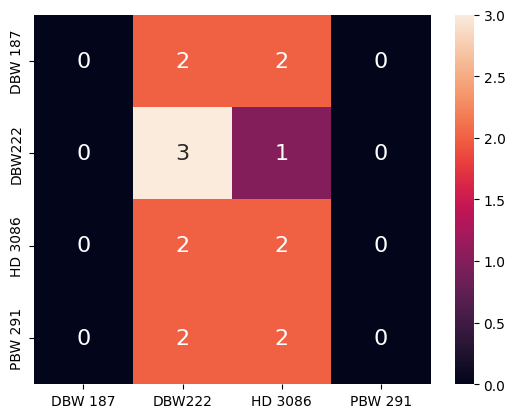

In [38]:
df_cm = pd.DataFrame(cm,index =[i for i in VARIETIES],columns=[i for i in VARIETIES])
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='.0f') # font size

plt.show()